In [1]:
import os
import pandas as pd
import torch
import torchvision
import d2l

# dataset

In [4]:
d2l.DATA_HUB["banana-detection"] = (
    d2l.DATA_URL + "banana-detection.zip",
    "5de26c8fce5ccdea9f91267273464dc968d20d72",
)

In [5]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract("banana-detection")
    csv_fname = os.path.join(
        data_dir, "bananas_train" if is_train else "bananas_val", "label.csv"
    )
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index("img_name")
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image(
                os.path.join(
                    data_dir,
                    "bananas_train" if is_train else "bananas_val",
                    "images",
                    f"{img_name}",
                )
            )
        )
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [16]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""

    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print(
            "read "
            + str(len(self.features))
            + (f" training examples" if is_train else f" validation examples")
        )

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [17]:
# @save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(
        BananasDataset(is_train=True), batch_size, shuffle=True
    )
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False), batch_size)
    return train_iter, val_iter

In [18]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

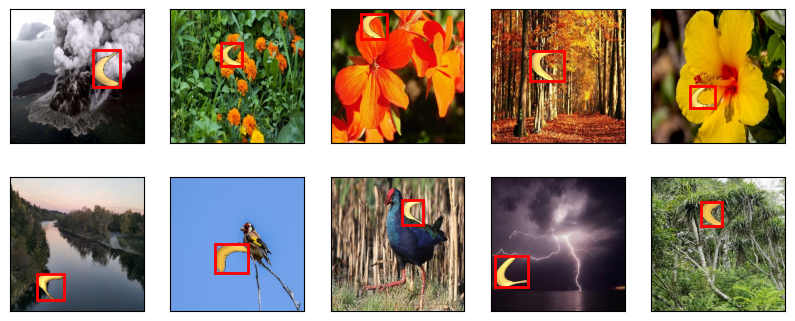

In [23]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=["r"])

# anchor box

In [36]:
torch.set_printoptions(10)  # 精简输出精度

In [74]:
# @save
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = num_sizes + num_ratios - 1
    # 锚框占图片比例
    size_tensor = torch.tensor(sizes, device=device)
    # 宽高比
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    # 图片高宽视为1 每一个像素的高宽
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h # shape=[561]
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing="ij")  # shape=[561, 728]
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w = (
        torch.cat(
            (
                size_tensor * torch.sqrt(ratio_tensor[0]),
                sizes[0] * torch.sqrt(ratio_tensor[1:]),
            )
        )
        * in_height
        / in_width
    )  # 处理矩形输入
    h = torch.cat(
        (
            size_tensor / torch.sqrt(ratio_tensor[0]),
            sizes[0] / torch.sqrt(ratio_tensor[1:]),
        )
    )
    # 除以2来获得半高和半宽
    anchor_manipulations = (
        torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    )

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack(
        [shift_x, shift_y, shift_x, shift_y], dim=1
    ).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [75]:
img = d2l.plt.imread('imgs/catdog.png')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
print(X.shape)

data = X
sizes=[0.75, 0.5, 0.25] 
ratios=[1, 2, 0.5]

Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728
torch.Size([1, 3, 561, 728])


torch.Size([1, 2042040, 4])

In [76]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.0551167727, 0.0715240538, 0.6330700517, 0.8215240240])

In [77]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

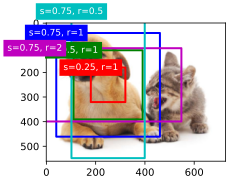

In [78]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

In [66]:
ones = torch.ones(2)
zeros = torch.zeros(3)
torch.meshgrid(ones, zeros)

(tensor([[1., 1., 1.],
         [1., 1., 1.]]),
 tensor([[0., 0., 0.],
         [0., 0., 0.]]))